In [1]:
import pandas as pd
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
import numpy as np
import matplotlib.pyplot as plt
from lifelines.statistics import logrank_test
import seaborn as sns
from scipy import stats
from statsmodels.stats.multitest import multipletests

# Mutation 

In [2]:
mutations = pd.read_csv('TCGA.HNSC.mutations.txt', sep='\t', header=0, index_col = [0])
mutations = mutations[mutations['Variant_Type'] == 'SNP' ]
mutations = mutations[mutations['Variant_Classification'] != 'Silent']

mutations['count'] = 1
mutation_counts = pd.pivot_table(mutations, values='count', index=mutations.index, columns='Variant_Classification', aggfunc='sum', fill_value=0)
mutation_counts

Variant_Classification,3'Flank,3'UTR,5'Flank,5'UTR,Intron,Missense_Mutation,Nonsense_Mutation,Nonstop_Mutation,RNA,Splice_Site,Translation_Start_Site
patient_id,,,,,,,,,,,
TCGA-4P-AA8J,0,2,0,5,2,92,8,0,2,2,0
TCGA-BA-4074,1,6,0,2,5,106,8,0,2,1,1
TCGA-BA-4075,0,13,2,4,9,113,10,0,3,4,0
TCGA-BA-4076,1,20,3,13,11,251,21,0,11,10,0
TCGA-BA-4077,1,16,1,10,11,234,20,0,5,6,0
...,...,...,...,...,...,...,...,...,...,...,...
TCGA-UF-A7JT,1,5,0,3,6,152,10,0,3,3,0
TCGA-UF-A7JV,0,6,1,1,3,52,8,0,1,2,0
TCGA-UP-A6WW,0,1,0,1,1,31,1,0,0,1,0


# Gene Expression

## OS Analysis

In [3]:
mutated_genes =  pd.read_csv('Mutated_Genes.txt', sep='\t', header=0)
metadata = pd.read_csv('TCGA.HNSC.metadata.txt', sep='\t', header=0, index_col = [0])

In [4]:
mutated_genes = mutated_genes.sort_values(by=['# Mut'],ascending=False)[:100].reset_index(drop = True)

In [5]:
gene_list = np.array(mutated_genes['Gene'])

In [6]:
# add 'CEACAM5', 'CEACAM6', 'CLCA4' 'EGFR' in array bc their prevalence in cancer gene
gene_list = np.append(gene_list, np.array(['CEACAM5', 'CEACAM6', 'CLCA4', 'EGFR']))

In [7]:
# Load the gene expression data
gene_expression_data = pd.read_csv('TCGA.HNSC.expression.txt', delimiter='\t')

# Remove everything after '|' in column names
gene_expression_data.columns = gene_expression_data.columns.str.split('|', expand=True).get_level_values(0)
gene_expression_data

# Filter the gene list based on the available columns
selected_genes = [gene for gene in gene_list if gene in gene_expression_data.columns]

# Select the desired genes from the gene expression data
selected_genes_data = gene_expression_data[['patient_id', 'sample_id'] + selected_genes]


In [8]:
metadata['sample_id'] = metadata.index.str.split(' ').str[0]

In [9]:
merged_data = metadata.merge(selected_genes_data, on="patient_id") 

In [10]:
merged_data['OS.time'] = merged_data['OS.time']/365

In [11]:
merged_data = merged_data[merged_data['OS.time'] <= 5]

# Kaplan–Meier estimator and log rank test

In [12]:
def quantile_gene(x):
    q1 = merged_data[x].quantile(0.1)
    q3 = merged_data[x].quantile(0.9)
    merged_data[ x + 'binary'] = merged_data[x].apply(lambda x: 0 if x <= q1 else 1 if x >= q3 else np.nan)

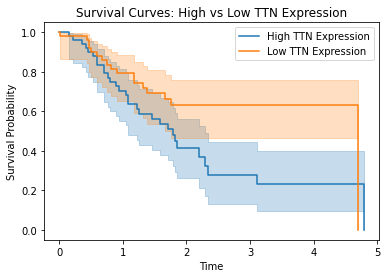

High expression has 49 samples. Low expression has 49 samples.
Significant gene for survival analysis TTN. P values: 0.030777376732190238


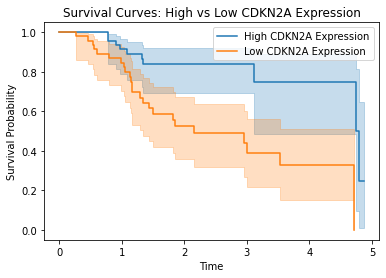

High expression has 49 samples. Low expression has 49 samples.
Significant gene for survival analysis CDKN2A. P values: 0.0003307836931788952


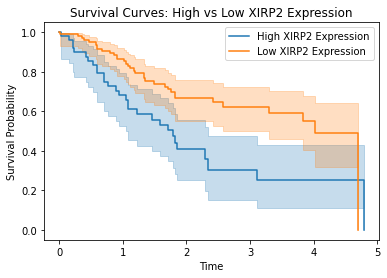

High expression has 49 samples. Low expression has 97 samples.
Significant gene for survival analysis XIRP2. P values: 0.002798073236727494


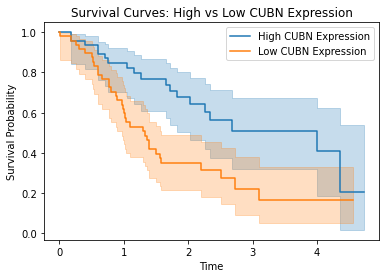

High expression has 49 samples. Low expression has 49 samples.
Significant gene for survival analysis CUBN. P values: 0.0024055259699616084


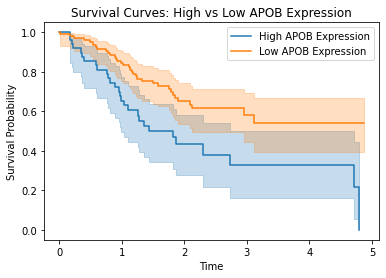

High expression has 49 samples. Low expression has 98 samples.
Significant gene for survival analysis APOB. P values: 0.0030694610053319305


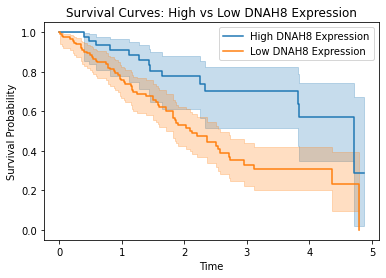

High expression has 49 samples. Low expression has 114 samples.
Significant gene for survival analysis DNAH8. P values: 0.0018883494126798735


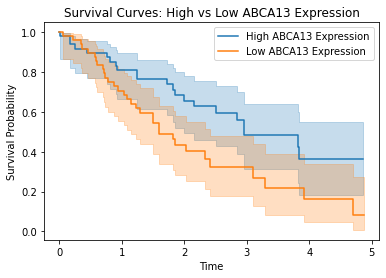

High expression has 49 samples. Low expression has 49 samples.
Significant gene for survival analysis ABCA13. P values: 0.016148945843168134


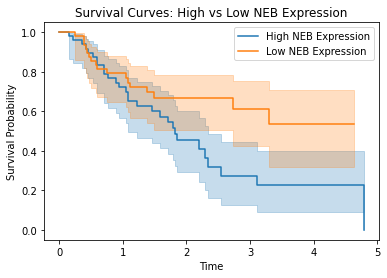

High expression has 49 samples. Low expression has 49 samples.
Significant gene for survival analysis NEB. P values: 0.03602164332583973


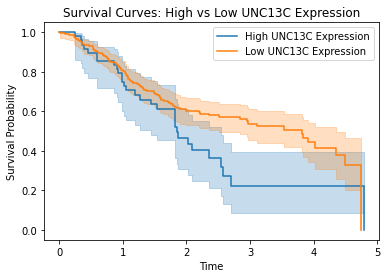

High expression has 49 samples. Low expression has 230 samples.
Significant gene for survival analysis UNC13C. P values: 0.04789486084023531


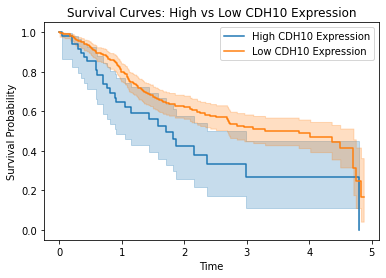

High expression has 49 samples. Low expression has 309 samples.
Significant gene for survival analysis CDH10. P values: 0.004985924086540276


In [13]:
for i in gene_list:
    if i in merged_data.columns:
        quantile_gene(i)
        low_expression = merged_data[merged_data[i + 'binary'] == 0]
        high_expression =  merged_data[merged_data[i +'binary'] == 1]
        # logrank
        results = logrank_test(high_expression['OS.time'], low_expression['OS.time'],
                       high_expression['OS'], low_expression['OS'])
        pvalue = results.p_value
        if pvalue < 0.05:
            kmf = KaplanMeierFitter()

            # Fit the survival curves for high and low expression groups
            kmf.fit(high_expression['OS.time'], event_observed=high_expression['OS'], label='High ' + i + ' Expression')
            kmf.plot()

            kmf.fit(low_expression['OS.time'], event_observed=low_expression['OS'], label='Low ' + i + ' Expression')
            kmf.plot()

            # Add labels and legend
            plt.xlabel('Time')
            plt.ylabel('Survival Probability')
            plt.title('Survival Curves: High vs Low ' + i + ' Expression')
            plt.legend()

            # Show the plot
            plt.show()
            print('High expression has ' + str(len(high_expression)) + ' samples. Low expression has '
                  + str(len(low_expression)) + ' samples.')
            print("Significant gene for survival analysis " + i + ". P values: " + str(pvalue))

<AxesSubplot:xlabel='CDKN2A', ylabel='ajcc_pathologic_tumor_stage'>

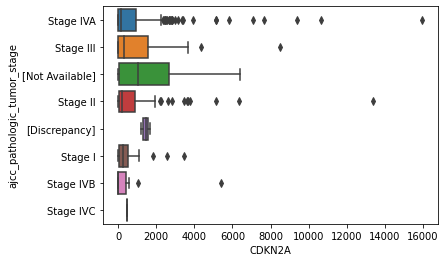

In [14]:
# Explore association between biomarker and potential confounding factors
sns.boxplot(x='CDKN2A', y='ajcc_pathologic_tumor_stage', data=merged_data)
# This creates a boxplot to visualize the distribution of age for different biomarker groups


<AxesSubplot:xlabel='CDKN2A', ylabel='tumor_status'>

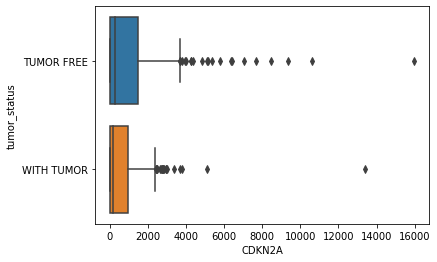

In [15]:
sns.boxplot(x='CDKN2A', y='tumor_status', data=merged_data)
# This creates a boxplot to visualize the distribution of tumor grade for different biomarker groups


<AxesSubplot:xlabel='OS', ylabel='tumor_status'>

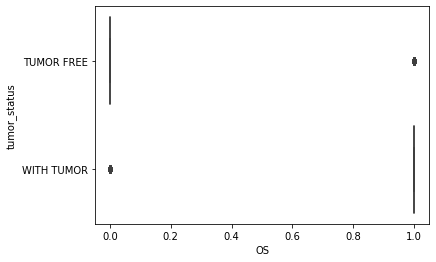

In [16]:
sns.boxplot(x='OS', y='tumor_status', data=merged_data)
# This creates a boxplot to visualize the distribution of tumor grade for different survival outcome groups


/var/folders/x1/0pbqqytx7775hcm5ys9z97y00000gn/T/ipykernel_57622/1026155058.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = merged_data[['CDKN2A', 'ajcc_pathologic_tumor_stage', 'tumor_status', 'OS']].corr()


<AxesSubplot:>

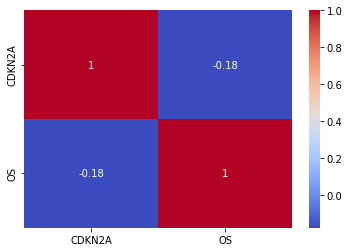

In [17]:
# Compute correlation coefficients between variables
correlation_matrix = merged_data[['CDKN2A', 'ajcc_pathologic_tumor_stage', 'tumor_status', 'OS']].corr()

# Display correlation matrix as a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

In [18]:
# perform statistical tests such as t-tests, chi-square tests, or regression models to assess associations

# Example chi-square test for tumor grade and survival outcome
cross_tab = pd.crosstab(merged_data['tumor_status'], merged_data['OS'])
chi2_statistic, p_value, _, _ = stats.chi2_contingency(cross_tab)
print("Chi-square statistic:", chi2_statistic)
print("P-value:", p_value)

# Perform other statistical tests or models as needed based on your data and research objectives

Chi-square statistic: 166.72754821808766
P-value: 3.8365638232899474e-38


# Cox proportional hazards regression

In [19]:
def coxfitter(data, duration, event):
    # Define the CoxPHFitter object
    cph = CoxPHFitter()
    # Fit the model to your data
    cph.fit(data, duration_col= duration, event_col=event)
    summary = cph.summary
    return summary

In [20]:
for i in gene_list:
    if i in merged_data.columns:
        a = merged_data.dropna(subset = [(i + 'binary')])
        summary = coxfitter(a[[i ,'OS.time', 'OS']], 'OS.time', 'OS')
        if any(summary['p'] < 0.05):  # if any predictor has p-value less than 0.05
            print(summary['p'])

covariate
CDKN2A    0.000568
Name: p, dtype: float64
covariate
AHNAK    0.035465
Name: p, dtype: float64
covariate
CUBN    0.003534
Name: p, dtype: float64
covariate
ZFHX4    0.014484
Name: p, dtype: float64
covariate
ABCA13    0.012632
Name: p, dtype: float64
covariate
RP1    0.019506
Name: p, dtype: float64
covariate
CDH10    0.03041
Name: p, dtype: float64
covariate
MGAM    0.021745
Name: p, dtype: float64
covariate
CTNND2    0.038741
Name: p, dtype: float64
covariate
SVEP1    0.045641
Name: p, dtype: float64


In [21]:
# preprocessing for other convariates
gene = merged_data.copy()
#drop race which is not available or unknown or not evaluated
gene = gene[gene['ajcc_pathologic_tumor_stage'] != '[Not Available]']
gene = gene[gene['ajcc_pathologic_tumor_stage'] != '[Discrepancy]']
gene['gender'] = gene['gender'].map({'MALE': 1, 'FEMALE': 0})
gene['ajcc_pathologic_tumor_stage'] = gene['ajcc_pathologic_tumor_stage'].apply(lambda x:  
                                                                                0 if (x == 'Stage IVA' 
                                                                                or x == 'Stage IVB' or 
                                                                               x =='Stage IVC') else 1)

gene['age'] = gene['age_at_initial_pathologic_diagnosis'].apply(lambda x:  0 if x > 50 else 1)

In [22]:
cph = CoxPHFitter()
# Fit the model to your data
cph.fit(gene[['age_at_initial_pathologic_diagnosis','gender','ajcc_pathologic_tumor_stage', 'OS.time', 'OS']], duration_col= 'OS.time', event_col= 'OS')
cph.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
age_at_initial_pathologic_diagnosis,0.021543,1.021777,0.006617,0.008574,0.034512,1.008611,1.035114,0.0,3.255739,0.001131,9.788215
gender,-0.253123,0.776372,0.159196,-0.565141,0.058895,0.568280,1.060664,0.0,-1.590012,0.111832,3.160594
ajcc_pathologic_tumor_stage,-0.564383,0.568711,0.155308,-0.868780,-0.259986,0.419463,0.771063,0.0,-3.633969,0.000279,11.806960


# FDR corrections

In [23]:
signi = []
pvals = []
pvals_correct = []
for i in gene_list:
    if i in gene.columns:
        summary = coxfitter(gene[[i ,'gender','ajcc_pathologic_tumor_stage', 
                                         'age', 'OS.time', 'OS']], 'OS.time', 'OS')
        p_values = summary["p"]
        rejected, pvals_corrected = multipletests(p_values, method='fdr_bh')[:2]
        summary['p_corrected'] = pvals_corrected
        p = summary.loc[i, "p"]
        p_correct = summary.loc[i, "p_corrected"]
        pvals.append(p)
        pvals_correct.append(p_correct)
        signi.append(rejected[0])
genes = [col for col in gene_list if col in gene.columns]  # list of genes
# Create a DataFrame with the results
results = pd.DataFrame({'gene': genes,'p': pvals,'p_corrected': pvals_correct, 'significant': signi})
results[results['p_corrected'] < 0.05]



,gene,p,p_corrected,significant
3,MUC16,0.015575,0.022201,True
6,CDKN2A,0.007053,0.014106,True
22,AHNAK,0.013752,0.027504,True
42,DNAH9,0.030695,0.040927,True
46,LRP2,0.027549,0.036732,True
54,RP1,0.009675,0.019349,True
60,CDH10,0.000012,0.000049,True
82,CTNND2,0.000926,0.002282,True
94,CLCA4,0.000124,0.000494,True


## DSS analysis

# Kaplan–Meier estimator and log rank test

In [24]:
merged_data = metadata.merge(selected_genes_data, on="patient_id") 
merged_data = merged_data.dropna(subset = ['DSS.time', 'DSS'])
merged_data['DSS.time'] = merged_data['DSS.time']/365
merged_data = merged_data[merged_data ['DSS.time'] <= 5]

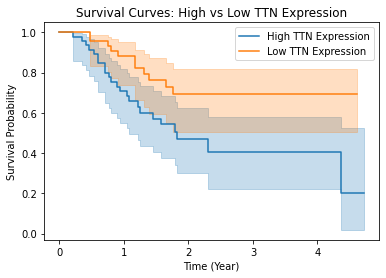

High expression has 46 samples. Low expression has 46 samples.
Significant gene for survival analysis TTN. P values: 0.013185837157289198


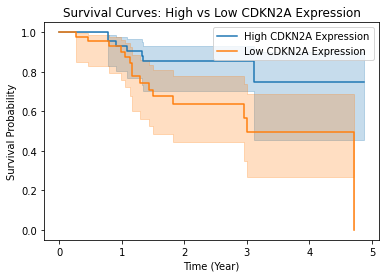

High expression has 46 samples. Low expression has 46 samples.
Significant gene for survival analysis CDKN2A. P values: 0.014654825819301224


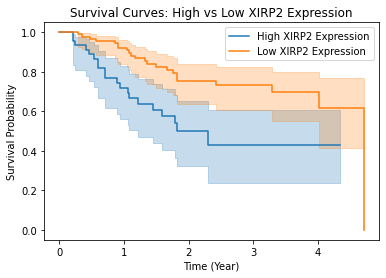

High expression has 46 samples. Low expression has 92 samples.
Significant gene for survival analysis XIRP2. P values: 0.0015625204243803644


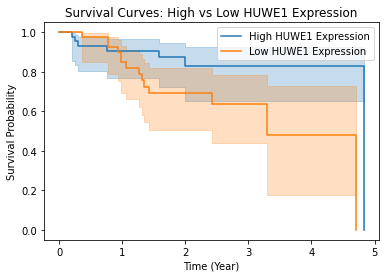

High expression has 46 samples. Low expression has 46 samples.
Significant gene for survival analysis HUWE1. P values: 0.043161461524451154


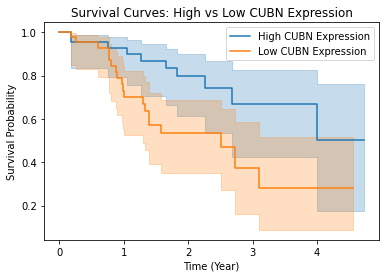

High expression has 46 samples. Low expression has 46 samples.
Significant gene for survival analysis CUBN. P values: 0.01394902402930436


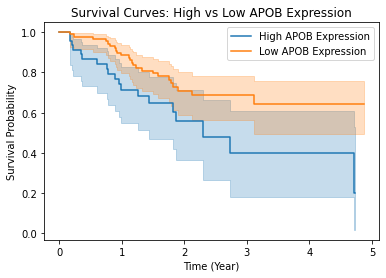

High expression has 46 samples. Low expression has 93 samples.
Significant gene for survival analysis APOB. P values: 0.015262736056733738


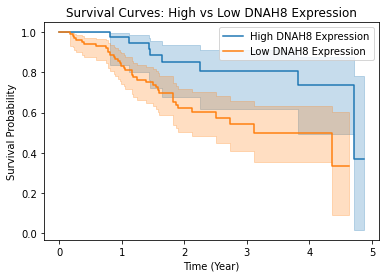

High expression has 46 samples. Low expression has 106 samples.
Significant gene for survival analysis DNAH8. P values: 0.007298211533103515


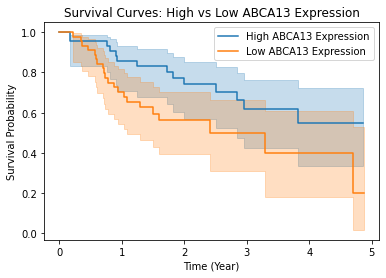

High expression has 46 samples. Low expression has 46 samples.
Significant gene for survival analysis ABCA13. P values: 0.04716570071451562


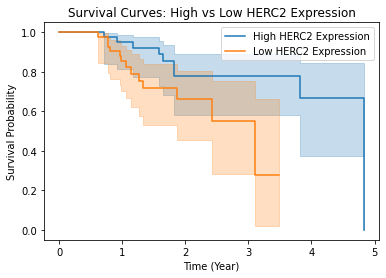

High expression has 46 samples. Low expression has 46 samples.
Significant gene for survival analysis HERC2. P values: 0.03520076507272263


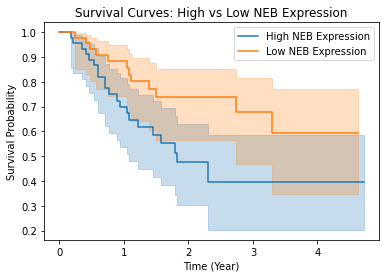

High expression has 46 samples. Low expression has 46 samples.
Significant gene for survival analysis NEB. P values: 0.028794504122930255


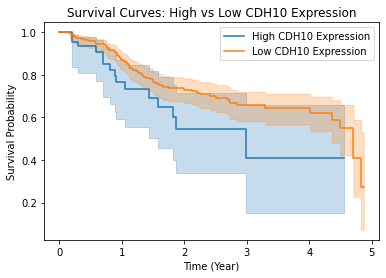

High expression has 46 samples. Low expression has 292 samples.
Significant gene for survival analysis CDH10. P values: 0.0455254105817322


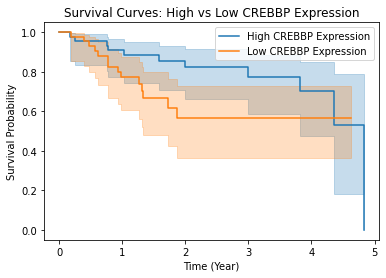

High expression has 46 samples. Low expression has 46 samples.
Significant gene for survival analysis CREBBP. P values: 0.041111608795104886


In [25]:
for i in gene_list:
    if i in merged_data.columns:
        quantile_gene(i)
        low_expression = merged_data[merged_data[i + 'binary'] == 0]
        high_expression =  merged_data[merged_data[i +'binary'] == 1]
        # logrank
        results = logrank_test(high_expression['DSS.time'], low_expression['DSS.time'],
                       high_expression['DSS'], low_expression['DSS'])
        pvalue = results.p_value
        if pvalue < 0.05:
            kmf = KaplanMeierFitter()

            # Fit the survival curves for high and low expression groups
            kmf.fit(high_expression['DSS.time'], event_observed=high_expression['DSS'], label='High ' + i + ' Expression')
            kmf.plot()

            kmf.fit(low_expression['DSS.time'], event_observed=low_expression['DSS'], label='Low ' + i + ' Expression')
            kmf.plot()

            # Add labels and legend
            plt.xlabel('Time (Year)')
            plt.ylabel('Survival Probability')
            plt.title('Survival Curves: High vs Low ' + i + ' Expression')
            plt.legend()

            # Show the plot
            plt.show()
            print('High expression has ' + str(len(high_expression)) + ' samples. Low expression has '
                  + str(len(low_expression)) + ' samples.')
            print("Significant gene for survival analysis " + i + ". P values: " + str(pvalue))

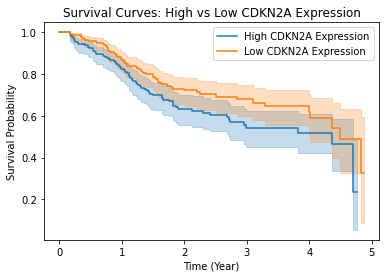

   test_statistic         p  -log2(p)
0         4.45287  0.034843  4.843002


In [26]:
median_value = merged_data['CDKN2A'].median()
#Split the data into high and low TP53 expression groups
high_expression = merged_data[merged_data['CDKN2A'] < median_value]
low_expression = merged_data[merged_data['CDKN2A'] > median_value]

# Initialize Kaplan-Meier estimator
kmf = KaplanMeierFitter()

# Fit the survival curves for high and low expression groups
kmf.fit(high_expression['DSS.time'], event_observed=high_expression['DSS'], label='High CDKN2A Expression')
kmf.plot()

kmf.fit(low_expression['DSS.time'], event_observed=low_expression['DSS'], label='Low CDKN2A Expression')
kmf.plot()

# Add labels and legend
plt.xlabel('Time (Year)')
plt.ylabel('Survival Probability')
plt.title('Survival Curves: High vs Low CDKN2A Expression')
plt.legend()

# Show the plot
plt.show()
from lifelines.statistics import logrank_test
results = logrank_test(high_expression['DSS.time'], low_expression['DSS.time'],
                       high_expression['DSS'], low_expression['DSS'])
print(results.summary)

# Cox proportional hazards regression

In [27]:
for i in gene_list:
    if i in merged_data.columns:
        summary = coxfitter(merged_data[[i ,'DSS.time', 'DSS']], 'DSS.time', 'DSS')
        if any(summary['p'] < 0.05):  # if any predictor has p-value less than 0.05
            print(summary['p'])

covariate
MUC16    0.01186
Name: p, dtype: float64
covariate
CDKN2A    0.0018
Name: p, dtype: float64
covariate
DNAH5    0.04218
Name: p, dtype: float64
covariate
AHNAK    0.045301
Name: p, dtype: float64
covariate
HUWE1    0.03028
Name: p, dtype: float64
covariate
DNAH9    0.012072
Name: p, dtype: float64
covariate
LRP2    0.01223
Name: p, dtype: float64
covariate
HERC2    0.011781
Name: p, dtype: float64
covariate
RP1    0.009415
Name: p, dtype: float64
covariate
CDH10    0.045908
Name: p, dtype: float64
covariate
CREBBP    0.020396
Name: p, dtype: float64
covariate
ZNF208    0.025835
Name: p, dtype: float64
covariate
ASPM    0.00578
Name: p, dtype: float64


In [28]:
# preprocessing for other convariates
gene = merged_data.copy()
#drop race which is not available or unknown or not evaluated
gene = gene[gene['ajcc_pathologic_tumor_stage'] != '[Not Available]']
gene = gene[gene['ajcc_pathologic_tumor_stage'] != '[Discrepancy]']


gene['gender'] = gene['gender'].map({'MALE': 1, 'FEMALE': 0})
gene['ajcc_pathologic_tumor_stage'] = gene['ajcc_pathologic_tumor_stage'].apply(lambda x:  
                                                                                0 if (x == 'Stage IVA' 
                                                                                or x == 'Stage IVB' or 
                                                                               x =='Stage IVC') else 1)
# convert age to binary young < 50 years old and elderly > 50 years old
gene['age'] = gene['age_at_initial_pathologic_diagnosis'].apply(lambda x:  0 if x > 50 else 1)

In [29]:
cph = CoxPHFitter()
# Fit the model to your data
cph.fit(gene[['gender','ajcc_pathologic_tumor_stage', 'age', 'DSS.time', 'DSS']], duration_col= 'DSS.time', event_col= 'DSS')
cph.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
gender,-0.191678,0.825573,0.201750,-0.587101,0.203745,0.555937,1.225986,0.0,-0.950074,0.342075,1.547617
ajcc_pathologic_tumor_stage,-0.594540,0.551816,0.196307,-0.979296,-0.209785,0.375576,0.810759,0.0,-3.028617,0.002457,8.669028
age,0.019864,1.020063,0.231485,-0.433837,0.473566,0.648018,1.605709,0.0,0.085812,0.931616,0.102193


# FDR corrections

In [30]:
signi = []
pvals = []
pvals_correct = []
for i in gene_list:
    if i in gene.columns:
        summary = coxfitter(gene[[i ,'gender','ajcc_pathologic_tumor_stage', 
                                         'age', 'DSS.time', 'DSS']], 'DSS.time', 'DSS')
        p_values = summary["p"]
        rejected, pvals_corrected = multipletests(p_values, method='fdr_bh')[:2]
        summary['p_corrected'] = pvals_corrected
        p = summary.loc[i, "p"]
        p_correct = summary.loc[i, "p_corrected"]
        pvals.append(p)
        pvals_correct.append(p_correct)
        signi.append(rejected[0])
genes = [col for col in gene_list if col in gene.columns]  # list of genes
# Create a DataFrame with the results
results = pd.DataFrame({'gene': genes,'p': pvals,'p_corrected': pvals_correct, 'significant': signi})
results[results['p_corrected'] < 0.05]


/Users/panbochen/opt/anaconda3/lib/python3.8/site-packages/lifelines/fitters/coxph_fitter.py:1611: ConvergenceWarning: Newton-Rhaphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(


,gene,p,p_corrected,significant
3,MUC16,0.007638,0.015276,True
11,DNAH5,0.018239,0.036479,True
42,DNAH9,0.003549,0.007098,True
54,RP1,0.002634,0.005268,True
60,CDH10,0.000072,0.000289,True
86,ASPM,0.015392,0.030785,True
94,CLCA4,0.014955,0.029911,True
